In [37]:
'''
Author = JdeWit
Date: 2019-08-15
email: J.deWit-1@tudelft.nl

This set of functions can be used for postprocessing of raw OCT data obtained 
with the THORLABS ganymede II OCT setup. It contains functions for Ascans, 
Bscans, dispersion compensation, resolution and SNR calculation and making dB
compressed images of Bscans. 
'''
import pdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import hilbert
from time import time
import numpy as np
import zipfile
from bs4 import BeautifulSoup

In [13]:
# mathematical functions used to fit
def linear(x,offset, slope):
    return offset+slope*x

def phasefie(x, offset, center, a1, a2, a3):
    return 2*np.pi*(offset + a1*(x-center)**2 + a2*(x-center)**3 + a3*(x-center)**4)

def phasefie2(x, offset, center, a1):
    return 2*np.pi*(offset + a1*(x-center)**2)

def gauss(x, ampl, x0, sigma):
    return ampl*np.exp(-(x-x0)**2/(2*sigma**2))

In [40]:
# these are OCT functions written by Jos

def calc_Ascan(raw0mean,spectrum,dechirp=0,popt=0,filters='none',objective='LK4',apodization='hanning'):
    '''
    This function calculates the Ascan from the raw data
    Input parameters:
        raw0mean: interference signal
        spectum: background spectrum from the reference arm
        dechirp: dechirp vector to interpolate the spectrum to a linear basis in k space
        popt: this can be a list of 5 parameters for dispersion correction according to the function phasefie.
            if the length of popt is not equal to 5, a dispersion correction is taken from the function
            getSavedDispersionCorrection, based on the filters and objective.
        filters: this is whether there is a filter inserted between the objective lens and the sample. 
            objective: which objective is used (choice between LK2 and LK4, LK4 is default)
        apodization: apodization of the spectrum. In case this is 'none', the original spectrum is used as apodization.
            The input can be 'hanning', 'hamming', or a custom apodization with the same length as the spectrum.
    output parameters:
        Ascan_z: the complex values Ascan
    '''
    interference_signal=raw0mean-spectrum
    
    # calculate the apodization vector
    if apodization=='hanning':
        apodization_vector=np.hanning(np.size(spectrum))/spectrum
    elif apodization=='none':
        apodization_vector=1
    elif apodization=='hamming':
        apodization_vector=np.hamming(np.size(spectrum))/spectrum
    elif np.size(apodization)==np.size(spectrum):
        apodization_vector=apodization/spectrum
    # apply the apodization vector to the signal    
    interference_signal=interference_signal*apodization_vector
    
    if np.size(dechirp)==1:
        dechirp=np.fromfile('modules\\Chirp.data',np.float32)
    f = interp1d(dechirp, interference_signal, kind='cubic')
    m=np.linspace(0,len(raw0mean)-1, len(raw0mean))
    int0meancorr = f(m)
    if np.size(popt)==5:
        popt0=popt
    else:
        popt0=getSavedDispersionCorrection(filters,objective)
    int0meanphase=int0meancorr*np.exp(1j*phasefie(m, popt0[0], popt0[1], popt0[2], popt0[3], popt0[4]))
    Ascan_z=np.fft.fftshift(np.fft.ifft(int0meanphase))
    return Ascan_z

def calc_Bscan(raw0,ref_spectrum,dechirp=0,Ascanav=1,apodization='hanning',objective='LK4',filters='none'):
    '''
    This function calculates the Bscan from the raw data
    If there is an Ascan average given, the Ascans will be averaged after they are calculated
    '''
    if np.size(dechirp)==1:
        dechirp=np.fromfile('modules\\Chirp.data',np.float32)
    Bscan=np.empty([int(np.shape(raw0)[1]),int(raw0.shape[0])],dtype=np.complex64)
    for i in range(int(raw0.shape[0])):
        Bscan[:,i]=calc_Ascan(raw0[i,:],ref_spectrum,dechirp,apodization=apodization,filters=filters)
    if Ascanav>1:
        N=int(raw0.shape[0]/Ascanav)
        Bscan2=np.empty([int(raw0.shape[1]),N],dtype=np.complex64)
        for i in range(N):
            Bscan2[:,i]=np.average(Bscan[:,i*Ascanav:(i+1)*Ascanav],axis=1)
        Bscan=Bscan2
    return Bscan[int(Bscan.shape[0]/2):,:]

def calc_Bscan2(raw0,ref_spectrum,dechirp=0,Ascanav=1,apodization='hanning',objective='LK4',filters='none'):
    '''
    This function calculates the Bscan from the raw data. 
    If there is an Ascan average given, the Ascans will be averaged after they are calculated
    It has the same input and output as calc_Bscan2, but it is slightly faster when the Ascan average is large
    output parameters:
        Bscan: the Bscan in the z>0 region
    '''
    if np.size(dechirp)==1:
        dechirp=np.fromfile('modules\\Chirp.data',np.float32)
    if Ascanav>1:
        N=int(raw0.shape[0]/Ascanav)
        Bscan=np.empty([int(raw0.shape[1]),N],dtype=np.complex64)
        for i in range(N):
            for j in range(Ascanav):
                Bscan[:,i]=Bscan[:,i]+calc_Ascan(raw0[Ascanav*i+j,:],ref_spectrum,dechirp,apodization=apodization,filters=filters)
        Bscan=Bscan/Ascanav
    else: 
        Bscan=np.empty([int(np.shape(raw0)[1]),int(raw0.shape[0])],dtype=np.complex64,apodization=apodization,filters=filters)
        for i in range(int(raw0.shape[0])):
            Bscan[:,i]=calc_Ascan(raw0[i,:],ref_spectrum,dechirp)
    return Bscan[int(Bscan.shape[0]/2):,:]
            
# plot image
def plot_Bscan_image(image_data,dBlevel=80,FOV=0,title='image (dB)',plot_no=0):
    '''
    This function gives a plot of the Bscan image. The input is the image 
    data before log compressing. The image data may be complex values as 
    first the absolute value is taken and then the data is log compressed.
    input parameters:
        image_data: a matrix with the Bscan image before log compression. It may be complex valued or not.
        dBlevel: dB level of the image
        FOV: the field of view. This can be a list with the FOV in [z,x,y] respectively
            if FOV[1]==0 or FOV is a scalar, the image will be plot with pixels on the axis rather than mm
        title: the title of the image
        plot_no: the figure number. If it is 0, a new figure will be opened.
        
    output parameters
        fig: the figure as object
    '''
    dB_im=20*np.log(np.abs(image_data))/np.log(10)
    dB_im=dB_im-np.max(dB_im)
    if plot_no==0:
        fig=plt.figure()
    else:
        fig=plt.figure(plot_no)
    if np.size(FOV)==1 or FOV[1]==0:
        plt.imshow(dB_im-np.max(dB_im))
        plt.xlabel('x (pixel)')
        plt.ylabel('z (pixel)')
    else:
        FOVmm=FOV*1e3
        extent=(0,FOVmm[1], FOVmm[0],0)
        plt.imshow(dB_im-np.max(dB_im),extent=extent)
        plt.xlabel('x (mm)')
        plt.ylabel('z (mm)')
    plt.clim(-dBlevel,0)
    plt.colorbar()
    plt.title(title)
    return fig
        
# analysis of the images/Ascans
def calc_resolution(Ascan_z,FOVz,start=1024,end=-1):
    '''
    This function has as input an Ascan (which can be complex), the FOV as 
    as well as the start and end positions of the region where the fit is
    done. In this region a gaussian fit is done around the highest position 
    and the output is the maximum value in the fit region, the amplitude of 
    the Gaussian, the position of the gaussian peak and the FWHM respectively.
    If the fit doesn't work The peak amplitude and position of the gaussian 
    are replaced by the value and position of the maximum within the fit area.
    then FWHM is set to 0.
    '''
    length=np.size(Ascan_z)
    pix_size=2*FOVz/length
    if end==-1:
        end=length-1
    z=np.linspace(-FOVz,FOVz-pix_size,length)
    zfit=z[int(start):int(end)]
    yfit=np.abs(Ascan_z[int(start):int(end),])
    peak2=np.amax(yfit)
    sigma_guess=pix_size
    try:
        poptga,pcov = curve_fit(gauss, zfit, yfit, p0=[peak2,zfit[np.argmax(yfit)],sigma_guess])
    except RuntimeError:
            poptga=[peak2,zfit[np.argmax(yfit)],0]
    # if the peak position of the fit is outside the FOV, take just the maximum
    # and the position of the maximum as position. Set FWHM to 0
    if (poptga[1]>FOVz) or (poptga[1]<0):
            poptga=[peak2,zfit[np.argmax(yfit)],0]
    FWHM=2*np.sqrt(2*np.log(2))*np.abs(poptga[2])
    
    return [peak2,poptga[0],poptga[1],FWHM]

def calc_SNR(Ascan,FOVz,peak_z_position,peak_power=0):
    '''
    This function calculates the SNR of a peak at peak_z_position. The 
    variance of the noise is calculated over the area peak +50 to peak + 250 
    pixels and the SNR is obtained as 10*log(peak_power**2/var(noise area))
    '''
    if peak_power==0:
        peak_power=np.max(np.abs(Ascan))
    SNRleft=min(int((peak_z_position/FOVz*1024+1024)+50),np.size(Ascan)-3)
    SNRright=min(int((peak_z_position/FOVz*1024+1024)+250),np.size(Ascan)-1)
    SNR=10*np.log((peak_power)**2/np.var(np.abs(Ascan[SNRleft:SNRright])))/np.log(10)
    return SNR

# dispersion compensation
def getSavedDispersionCorrection(filters='none',objective='LK4'):
    '''
    This function stores the dispersion correction coefficients that can be 
    used in the function phasefie for different filters before the reflector.
    The values are calculated from measurements on July 25th 2019
    '''
    if objective=='LK4':
        if filters=='none':
            popt=np.array([1.89661316e-01,9.03297521e+02,-1.26040492e-06,3.47924225e-10,2.18852572e-13])
        elif filters=='ND1':
            popt=np.array([])
        elif filters=='ND1ND2' or filters=='ND2ND1':
            popt=np.array([4.88499293e-01,8.99406248e+02,-3.01384740e-06,1.04388175e-09,4.76105923e-13])
        elif filters=='ND2':
            popt=np.array([3.40201240e-01,8.86972885e+02,-2.34963330e-06,8.34319018e-10,5.20372323e-13])
        elif filters=='biofilmbox':
            popt=[ 3.60740013e-02,  1.29951000e+03, -2.70536409e-06,  0.00000000e+00,0.00000000e+00]
    elif objective=='LK2':
        if filters=='none':
            popt=[-4.96060075e-02,1.35930305e+03,1.08000468e-06,1.67645752e-09,5.97355918e-13]
    return popt

def getDispersionCorrection(int0mean, dechirp=0,fit_range=[230,1790],plot=0):
    '''
     This function gives as output the coeficients used in phasefie that best
     correct for the dispersion. 
     Input parameters:
         int0mean: the net interference spectrum, for the fit to make sense, 
         there must be a single point/planar reflector in the experiment.
         dechirp: the vector that is used to interpolate the spectrum to a base
         that is linear in k
         fit_range: is the range where the phase fits are limited to
         plot: this determines whether the phase and the fit will be plot 
         (plot=1 means plot) it will be plot in figure 1
     if no optimal parameters are found, it will return a 0 array and print:
     'fail phasefie fit'. else it returns the parameters to be used in phasefie
    '''
    if np.size(dechirp)==1:
        dechirp=np.fromfile('modules\\Chirp.data',np.float32)
    length=int0mean.size
    m=np.linspace(0,length-1, length)

    f = interp1d(dechirp, int0mean, kind='cubic')
    int0meaninterp = f(m)
    int0analytical=hilbert(int0meaninterp)
    phaseint0=np.unwrap(np.angle(int0analytical))
    
    start=fit_range[0]
    end=fit_range[1]
    fitrange=np.linspace(start, end, end-start, dtype=int)
       
    poptlin,pcov = curve_fit(linear, m[fitrange], phaseint0[fitrange], p0=[0, 1])
    if plot==1:
        plt.figure(1, figsize=(8,10))
        plt.subplot(211)
        plt.plot(m[start:end], phaseint0[start:end], '-b')
        plt.plot(m, linear(m, poptlin[0], poptlin[1]), '--r')
        plt.grid()
    
    phasedev=phaseint0-linear(m, poptlin[0], poptlin[1])
    try:
        popt,pcov = curve_fit(phasefie, m[fitrange], phasedev[fitrange], p0=[-0.4, 1024, 1e-6, 0, 0], ftol=1e-20)
#        popt,pcov = curve_fit(phasefie2, m[fitrange], phasedev[fitrange], p0=[-0.4, 1024, 1e-6], ftol=1e-20)
#        popt=[popt[0],popt[1],popt[2],0,0]
    except:
        try:
            popt,pcov = curve_fit(phasefie2, m[fitrange], phasedev[fitrange], p0=[-0.4, 1024, 1e-6], ftol=1e-20)
            popt=[popt[0],popt[1],popt[2],0,0]
            print('power 2 polynome has been fit')
        except:            
            popt=np.zeros(5)
            print('fail phasefie fit')
    if plot==1:
        plt.subplot(212)
        plt.plot(m[fitrange], phasedev[fitrange], '-b')
        plt.plot(m, phasefie(m, popt[0], popt[1], popt[2], popt[3], popt[4]) , '-r')
        plt.grid()
    return popt

In [15]:
# here are the OCT functions from Thorlabs

def OCTgetDataCombined(filepath,spectrumindex=0):
    '''
    This function combines the functions below and gives the header, raw data, 
    spectrum and the field of view from the filepath.
    input parameters:
        filepath: path where the data file can be found including the file name
        spectrumindex:determine which Bscan to load the data from. This is 
            especially relevant for recordings with multiple Bscans or 3D datasets.
    output parameters:
        header: header containing the metadata of the measurement
        rawdata: file with the raw data (2D) from the OCT spectrometer 
            (compensated for the camera offset)
        spectrum: spectrum of the reference arm
        FOV: field of view, list with order [FOVz,FOVx,FOVy] in the 1D and 2D 
            mode it is a list with 2 items
    '''
    directory=OCTfileOpen(filepath)
    header=OCTreadHeader(directory)
    rawdata,spectrum=OCTgetRawData(directory,header,spectrumindex)
    FOV=OCTgetFOV(header)
    return [header,rawdata,spectrum,FOV]

def OCTfileOpen(filepath):
    '''
    this function creates pointer into the zip file where the header and the 
    data can be extracted from
    '''
    zip_ref = zipfile.ZipFile(filepath,'r')
    return zip_ref

def OCTreadHeader(directory):
    '''
    this function reads the header from the xml file in the directory that 
    is given as input
    '''
    file=directory.open('Header.xml')
    header=BeautifulSoup(file,'lxml-xml')
    return header

def OCTgetRawData(directory,header,spectrumindex=0):
    ''' 
    This function obtains the raw interference data with the indicated 
    spectrum index as well as the apodization spectrum for the measurement.
    Both the raw data and the apodization spectrum are corrected with the 
    offset
    input parameters:
        directory: pointer into the zip file 
        header: header corresponding to the measurements
        spectrumindex: determine which Bscan to load the data from. This is 
            especially relevant for recordings with multiple Bscans or 3D datasets.
    output parameters:
        raw2: the interference spectrum compensated for the camera offset.
        ApodizationSpectrum: the spectrum from the reference arm compensated 
            for the camera offset
    '''    
    # get offset
    offset_obj=directory.open('data/OffsetErrors.data')
    offset=offset_obj.read()
    offset=np.frombuffer(offset,dtype=np.float32)
    
    # get raw data
    bbPixel = int(header.Ocity.Instrument.BytesPerPixel.string)
    isSigned = header.Ocity.Instrument.RawDataIsSigned.string;
    if bbPixel==2:
        if isSigned=='False':
            dtype = np.uint16
        else:
            dtype = np.int16
    BinaryToElectronCountScaling=np.double(header.Ocity.Instrument.BinaryToElectronCountScaling.string)
    
    Raw_Data_File=header.find("DataFile",Type='Raw',string="data\Spectral"+str(spectrumindex)+".data")
    if not Raw_Data_File:
        print('Error: the desired spectrum is not found')
    else: 
        size=[int(Raw_Data_File['SizeX']),int(Raw_Data_File['SizeZ'])]
        ScanRegionStart0=int(Raw_Data_File['ScanRegionStart0'])
        try: 
            NumApos=int(Raw_Data_File['ApoRegionEnd0'])
        except:
            NumApos=0
             
        raw_data_obj=directory.open('data/Spectral'+str(spectrumindex)+'.data')
        raw_data=raw_data_obj.read()
        raw=np.frombuffer(raw_data,dtype)
        raw2=np.reshape(raw,size)*BinaryToElectronCountScaling
        for i in range(size[0]):
            raw2[i,:]=raw2[i,:]-offset
                    
    # get reference spectrum
    if NumApos==0:
        ApodizationSpectrum_obj=directory.open('data/ApodizationSpectrum.data')
        ApodizationSpectrum=ApodizationSpectrum_obj.read()
        ApodizationSpectrum=np.frombuffer(ApodizationSpectrum,dtype=np.float32)-offset
    else:
        ApodizationSpectrum=np.mean(raw2[0:NumApos,:],axis=0)
            
    # select raw data that makes up the scan
    if ScanRegionStart0>0:
        raw2=raw2[ScanRegionStart0:,:]
    
    return [raw2, ApodizationSpectrum]

def OCTgetVideoImage(filepath,imtype='RGB'):
    '''
    This function takes the VideoImage which is displayed with the probe camera
    and make this into an RGB, RGBA or alpha image file. 
    input parameters:
        filepath: the path to the .oct file where the image is stored in
        imtype: shows which channels are returned. Default is RGB. Other options 
        are RGBA and alpha.
    '''
    directory=OCTfileOpen(filepath)
    probeim_obj=directory.open('data/VideoImage.data')
    probeim=probeim_obj.read()
    probeim=np.frombuffer(probeim,dtype=np.uint8)
    
    header=OCTreadHeader(directory)
    Videoim_Data_File=header.find("DataFile",Type="Colored",string="data\VideoImage.data")
    SizeX=int(Videoim_Data_File['SizeX'])
    SizeZ=int(Videoim_Data_File['SizeZ'])
    
    probeim=probeim.reshape([SizeX,SizeZ,4])
    probeim=probeim[:,:,[2,1,0,3]]
    if imtype=='RGB':
        probeim=probeim[:,:,0:3]
    elif imtype=='alpha':
        probeim=probeim[:,:,3]
    elif imtype=='RGBA':
        probeim=probeim
    else:
        print('imtype '+str(imtype)+' is not recognized. RGBA is returned.')            
    return probeim.astype(np.uint8)
    
def OCTgetPreviewImage(filepath,imtype='RGB'):
    '''
    This function takes the PreviewImage which is displayed in Thorimage
    and make this into an RGB, RGBA or alpha image file. This only works when 
    processed data is stored in Thorimage
    input parameters:
        filepath: the path to the .oct file where the image is stored in
        imtype: shows which channels are returned. Default is RGB. Other options 
        are RGBA and alpha.
    '''
    directory=OCTfileOpen(filepath)
    probeim_obj=directory.open('data/PreviewImage.data')
    probeim=probeim_obj.read()
    probeim=np.frombuffer(probeim,dtype=np.uint8)
    
    header=OCTreadHeader(directory)
    Preview_im_Data_File=header.find("DataFile",Type="Colored",string="data\PreviewImage.data")
    SizeX=int(Preview_im_Data_File['SizeX'])
    SizeZ=int(Preview_im_Data_File['SizeZ'])
    
    probeim=probeim.reshape([SizeX,SizeZ,4])
    probeim=probeim[:,:,[2,1,0,3]]
    if imtype=='RGB':
        probeim=probeim[:,:,0:3]
    elif imtype=='alpha':
        probeim=probeim[:,:,3]
    elif imtype=='RGBA':
        probeim=probeim
    else:
        print('imtype '+str(imtype)+' is not recognized. RGBA is returned.')            
    return probeim.astype(np.uint8)

def OCTgetProcessedImage(filepath):
    '''
    This function takes the Processed image (Intensity.data) which is displayed 
    in Thorimage and make this into an RGB, RGBA or alpha image file. This only
    works when processed data is stored in Thorimage.
    input parameters:
        filepath: the path to the .oct file where the image is stored in
        imtype: shows which channels are returned. Default is RGB. Other options 
        are RGBA and alpha.
    '''
    directory=OCTfileOpen(filepath)
    probeim_obj=directory.open('data/Intensity.data')
    probeim=probeim_obj.read()
    probeim=np.frombuffer(probeim,dtype=np.single)
    
    header=OCTreadHeader(directory)
    mode = header.Ocity.MetaInfo.AcquisitionMode.string
    Processed_im_Data_File=header.find("DataFile",Type="Real",string="data\Intensity.data")
    SizeX=int(Processed_im_Data_File['SizeX'])
    SizeZ=int(Processed_im_Data_File['SizeZ'])
    
    if mode =='Mode3D':
        SizeY=int(Processed_im_Data_File['SizeY'])
        probeim = probeim.reshape([SizeY,SizeX,SizeZ])
    elif mode == 'Mode2D':
        probeim = probeim.reshape([SizeX,SizeZ])
        probeim = probeim.T
    else:
        probeim = 0
        print('acquisition mode not available in acquiring processed image')
        
    return probeim

def OCTgetFOV(header):
    '''
    This file extract the Field of View from the header and converts it into
    meters. The field of view is a list in order [FOVz,FOVx,FOVy]
    '''
    FOV=np.zeros(3)
    FOV[0]=np.double(header.Ocity.Image.SizeReal.SizeZ.string)
    if header.Ocity.MetaInfo.AcquisitionMode.string=="Mode2D":
        FOV[1]=np.double(header.Ocity.Image.SizeReal.SizeX.string)
        FOV=FOV[0:2]
    elif header.Ocity.MetaInfo.AcquisitionMode.string=="Mode3D":
        FOV[1]=np.double(header.Ocity.Image.SizeReal.SizeX.string)
        FOV[2]=np.double(header.Ocity.Image.SizeReal.SizeY.string)
    else:
        FOV=FOV[0:2]
    FOV=FOV*1e-3
    return FOV

datatesting\data\Default_0001_Mode2D.oct
It took  2.2465240955352783  s to load and process file  \Default_0001_Mode2D.oct


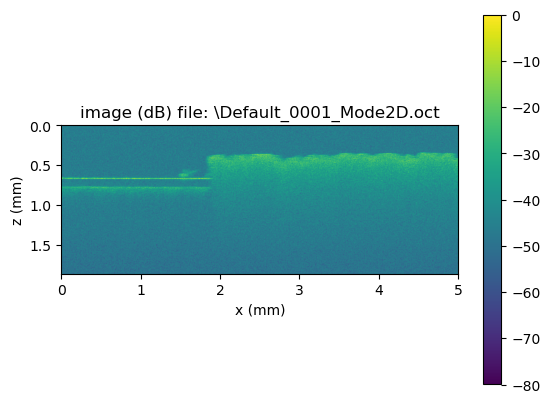

In [45]:
t0=time()
# load the data from the file specified above

dechirp=np.fromfile('modules\Chirp.data',np.float32)

#filename='datatesting\data\Default_0001_Mode2D.oct'

foldername='datatesting\data'
filename='\Default_0001_Mode2D.oct'

fullname=foldername+filename

print(fullname)

header,rawdata,spectrum,FOV=OCTgetDataCombined(fullname,spectrumindex=0)   
Ascanav=int(header.Ocity.Acquisition.IntensityAveraging.AScans.string)

# process the data into a Bscan image
image=calc_Bscan(rawdata,spectrum,dechirp,Ascanav,apodization='hanning',filters='none',objective='LK4')
t1=time()
print('It took ',t1-t0,' s to load and process file ',filename)
    
# plot the obtained image
plot_Bscan_image(image,dBlevel=80,FOV=FOV,title='image (dB) file: '+ filename, plot_no=0)
